## CAPSTONE PROJECT FINAL REPORT - Group: 007, Batch: AUG 22A

#### Project: COMPUTER VISION - 2 (OBJECT DETECTION – CAR)

#### Project Objective: Design a DL-Based Car Identification Model

# **Milestone 1:**


In [1]:
# Google colab pro to increase RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:

  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
from PIL import Image     # PIL for image manipulation
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")
import tensorflow
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Flatten, Conv2D, Reshape, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import keras
from keras.backend import sigmoid


In [3]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Step 1: Import the data

In [4]:
# Assigning the Google drive path
capstone_path = '/content/drive/My Drive/Capstone_project/'

In [5]:
# Reading the csv files
classNamesData = pd.read_csv(capstone_path+"Car+names+and+make.csv", header=None, names=["class_name"])
trainAnnotate = pd.read_csv(capstone_path+"Annotations/Train Annotations.csv")
testAnnotate = pd.read_csv(capstone_path+"Annotations/Test Annotation.csv")

In [6]:
# Rename the column names as per our convenience
trainAnnotate.rename(columns={'Image Name': 'image_file', 'Bounding Box coordinates': 'a0', 'Unnamed: 2':'b0','Unnamed: 3': 'a1','Unnamed: 4': 'b1', 'Image class':'class'}, inplace=True)
testAnnotate.rename(columns={'Image Name': 'image_file', 'Bounding Box coordinates': 'a0', 'Unnamed: 2':'b0','Unnamed: 3': 'a1','Unnamed: 4': 'b1', 'Image class':'class'}, inplace=True)

In [7]:
# Head the ClassNameData
classNamesData.head()

class_name
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

In [8]:
# Head the trainAnnotate
trainAnnotate.head()

image_file   a0   b0    a1    b1  class
0  00001.jpg   39  116   569   375     14
1  00002.jpg   36  116   868   587      3
2  00003.jpg   85  109   601   381     91
3  00004.jpg  621  393  1484  1096    134
4  00005.jpg   14   36   133    99    106

In [9]:
# Head the testAnnotate
testAnnotate.head()

image_file   a0   b0   a1   b1  class
0  00001.jpg   30   52  246  147    181
1  00002.jpg  100   19  576  203    103
2  00003.jpg   51  105  968  659    145
3  00004.jpg   67   84  581  407    187
4  00005.jpg  140  151  593  339    185

#### Step 2: Map training and testing images to its classes

In [10]:
# Defining the function to get image as a list
def get_image_list(image_path):
  train_image_dir = os.listdir(image_path)
  trainImageList=[]
  for i in train_image_dir:
    for f in os.listdir(os.path.join(image_path, i)):
        ext = os.path.splitext(f)[1]
        if ext == '.jpg' or ext == '.jpeg':
          trainImageList.append("{}/{}".format(i,f))
  return trainImageList

In [11]:
# Defining the function to map images with classes
def mapImageMetadata(image_base_path, annotateMetaData, image_path_list):
  image_path_lst_split = [i.split('/')[1] for i in image_path_list]
  annotateMetaData["car_image_path"] = annotateMetaData.apply(lambda row: image_base_path+'/'+ image_path_list[image_path_lst_split.index(row['image_file'])], axis=1)
  return annotateMetaData

In [12]:
# Calling the function for mapping the training images
train_imagePath = capstone_path+"/Car Images/Train Images"
train_imageList = get_image_list(train_imagePath)
train_Annotate = mapImageMetadata(train_imagePath, trainAnnotate, train_imageList)

In [13]:
train_Annotate.head()

image_file   a0   b0    a1    b1  class  \
0  00001.jpg   39  116   569   375     14   
1  00002.jpg   36  116   868   587      3   
2  00003.jpg   85  109   601   381     91   
3  00004.jpg  621  393  1484  1096    134   
4  00005.jpg   14   36   133    99    106   

                                      car_image_path  
0  /content/drive/My Drive/Capstone_project//Car ...  
1  /content/drive/My Drive/Capstone_project//Car ...  
2  /content/drive/My Drive/Capstone_project//Car ...  
3  /content/drive/My Drive/Capstone_project//Car ...  
4  /content/drive/My Drive/Capstone_project//Car ...

In [14]:
# Calling the function for mapping the testing images
test_imagePath = capstone_path+"/Car Images/Test Images"
test_imageList = get_image_list(test_imagePath)
test_Annotate = mapImageMetadata(test_imagePath, testAnnotate, test_imageList)

In [15]:
test_Annotate.head()

image_file   a0   b0   a1   b1  class  \
0  00001.jpg   30   52  246  147    181   
1  00002.jpg  100   19  576  203    103   
2  00003.jpg   51  105  968  659    145   
3  00004.jpg   67   84  581  407    187   
4  00005.jpg  140  151  593  339    185   

                                      car_image_path  
0  /content/drive/My Drive/Capstone_project//Car ...  
1  /content/drive/My Drive/Capstone_project//Car ...  
2  /content/drive/My Drive/Capstone_project//Car ...  
3  /content/drive/My Drive/Capstone_project//Car ...  
4  /content/drive/My Drive/Capstone_project//Car ...

#### Step 3: Map training and testing images to its annotations

In [16]:
# Lambda function to create a column to map train images and its annotation
train_Annotate['class_name'] = train_Annotate.apply(lambda x: classNamesData['class_name'][(x['class']-1)], axis=1)

In [17]:
train_Annotate.head()

image_file   a0   b0    a1    b1  class  \
0  00001.jpg   39  116   569   375     14   
1  00002.jpg   36  116   868   587      3   
2  00003.jpg   85  109   601   381     91   
3  00004.jpg  621  393  1484  1096    134   
4  00005.jpg   14   36   133    99    106   

                                      car_image_path  \
0  /content/drive/My Drive/Capstone_project//Car ...   
1  /content/drive/My Drive/Capstone_project//Car ...   
2  /content/drive/My Drive/Capstone_project//Car ...   
3  /content/drive/My Drive/Capstone_project//Car ...   
4  /content/drive/My Drive/Capstone_project//Car ...   

                            class_name  
0                  Audi TTS Coupe 2012  
1                  Acura TL Sedan 2012  
2           Dodge Dakota Club Cab 2007  
3     Hyundai Sonata Hybrid Sedan 2012  
4  Ford F-450 Super Duty Crew Cab 2012

In [18]:
# Lambda function to create a column to map test images and its annotation
test_Annotate['class_name'] = test_Annotate.apply(lambda x: classNamesData['class_name'][(x['class']-1)], axis=1)

In [19]:
test_Annotate.head()

image_file   a0   b0   a1   b1  class  \
0  00001.jpg   30   52  246  147    181   
1  00002.jpg  100   19  576  203    103   
2  00003.jpg   51  105  968  659    145   
3  00004.jpg   67   84  581  407    187   
4  00005.jpg  140  151  593  339    185   

                                      car_image_path  \
0  /content/drive/My Drive/Capstone_project//Car ...   
1  /content/drive/My Drive/Capstone_project//Car ...   
2  /content/drive/My Drive/Capstone_project//Car ...   
3  /content/drive/My Drive/Capstone_project//Car ...   
4  /content/drive/My Drive/Capstone_project//Car ...   

                            class_name  
0              Suzuki Aerio Sedan 2007  
1  Ferrari 458 Italia Convertible 2012  
2                Jeep Patriot SUV 2012  
3              Toyota Camry Sedan 2012  
4             Tesla Model S Sedan 2012

## EDA

#### Step 4: Display images with bounding box

In [20]:
# Creating a function to display the image
def display_image(image_path):
  image = cv2.imread(image_path,1)
  plt.imshow(image)
  plt.show()

In [21]:
# Creating a function to display the boundingbox
def boundingbox_image(df):
  Image_size = cv2.imread(df.car_image_path,1)
  a0=df.a0
  a1=df.a1
  b0=df.b0
  b1=df.b1

  fig, ax = plt.subplots(1)
  ax.imshow(Image_size)
  rect = patches.Rectangle((a0,b0), (a1-a0),(b1-b0),linewidth=2.5, edgecolor='g', facecolor='none')
  ax.add_patch(rect)
  plt.title(df.class_name)
  plt.show()

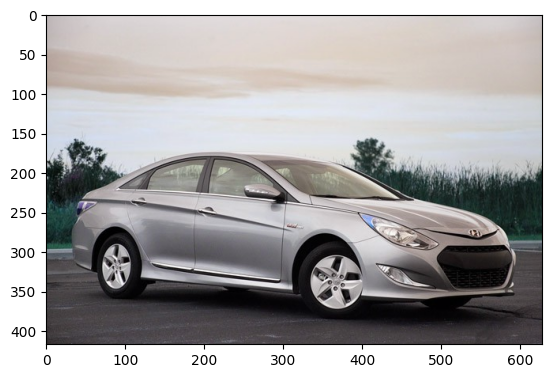

In [22]:
# Display a sample training image
df_train = train_Annotate.iloc[25]
display_image(df_train["car_image_path"])

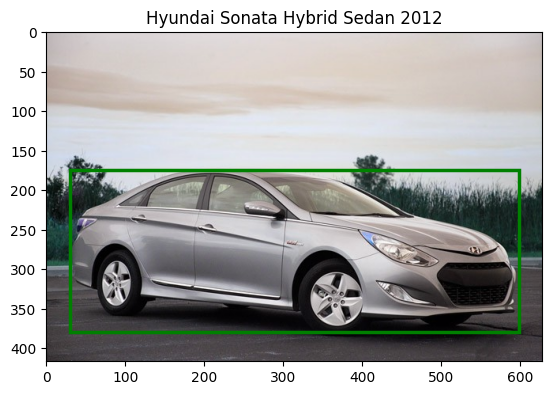

In [23]:
# Display a boundingbox for the same training image
boundingbox_image(df_train)

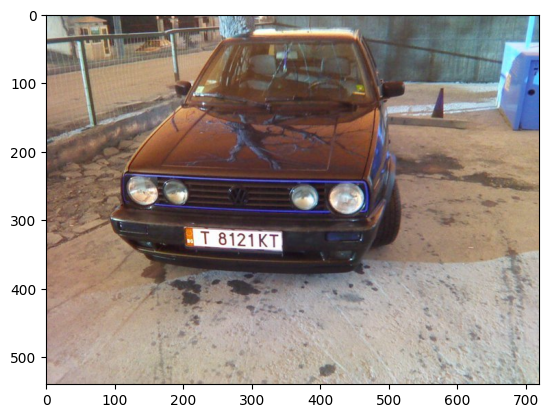

In [24]:
# Display a sample testing image
df_test = test_Annotate.iloc[25]
display_image(df_test["car_image_path"])

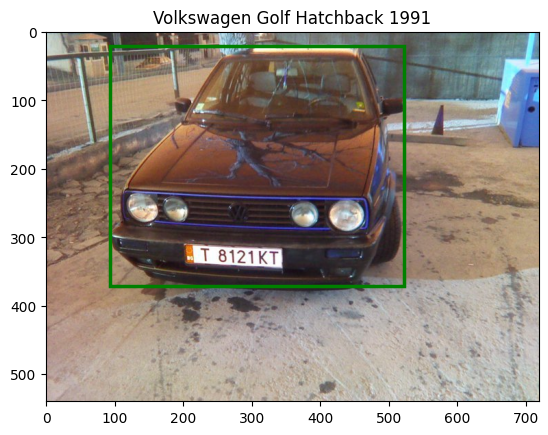

In [25]:
# Display a boundingbox for the same testing image
boundingbox_image(df_test)

Step 5: Design, train and test basic CNN models to classify the car

In [26]:
# Resizing image size to avoid the RAM error
Image_Height = 224
Image_Width = 224
Height_Cells= 32
Width_Cells = 32
Image_Size = 224
Alpha = 1

In [27]:
# Defining the function to resize all the images
def resizeImageData(annotate):
    resized_images = []
    images_boundingbox = []
    images_class = []

    for index, rows in annotate.iterrows():
        image = cv2.UMat(cv2.imread(rows['car_image_path'],1)).get()
        try:
          image_resized = cv2.resize(image,(Image_Width,Image_Height), interpolation = cv2.INTER_AREA)
          image_heightwidth = np.zeros((4,1), dtype=np.float32)
          image_heightwidth[0] = rows['a0']*Image_Width/image.shape[1]
          image_heightwidth[1] = rows['b0']*Image_Height/image.shape[0]
          image_heightwidth[2] = (rows['a1']-rows['a0'])*Image_Width/image.shape[1]
          image_heightwidth[3] = (rows['b1']-rows['b0'])*Image_Height/image.shape[0]

          images_boundingbox.append(image_heightwidth)
          resized_images.append(preprocess_input(np.array(image_resized, dtype=np.float32)))
          images_class.append(rows['class'])

          del image, image_resized, image_heightwidth
        except:
          break

    return resized_images, images_boundingbox, images_class

In [28]:
# Resizing the training images
#train_images, train_boundingbox, train_class = resizeImageData(train_Annotate)

In [29]:
# Assigning the data path to save the resized images
data_path = "/content/drive/My Drive/Capstone_project/"

In [30]:
# Save the resized train images in the data path

#np.save(data_path+"train_images.npy",train_images)
#np.save(data_path+"train_boundingbox.npy", train_boundingbox)
#np.save(data_path+"train_class.npy", train_class)

In [31]:
# Load the saved train images
train_images = np.load(data_path+"train_images.npy")
train_boundingbox = np.load(data_path+"train_boundingbox.npy")
train_class = np.load(data_path+"train_class.npy")

In [32]:
#test_images, test_boundingbox, test_class = resizeImageData(test_Annotate)

In [33]:
# Save the resized test images in the data path

#np.save(data_path+"test_images.npy",test_images)
#np.save(data_path+"test_boundingbox.npy", test_boundingbox)
#np.save(data_path+"test_classes.npy", test_class)

In [34]:
# Load the saved test images
test_images = np.load(data_path+"test_images.npy")
test_boundingbox = np.load(data_path+"test_boundingbox.npy")
test_class = np.load(data_path+"test_classes.npy")

Note: Due to the low RAM storage, We have saved the resized training and testing images in drive for future run.

In [35]:
# Defining the function for swish activation based sigmoid function
def swish(x, beta = 1):
    return (x*sigmoid(beta*x))

In [36]:
# Define the function for classification model
def generate_classification_model(trainable=True):
    model = MobileNetV2(input_shape=(224,224,3), alpha=1, include_top=False, weights='imagenet',
            classifier_activation='softmax')

    for layer in model.layers:
        layer.trainable = trainable

    x=model.output
    x=Dropout(0.2)(x)
    x=BatchNormalization(epsilon=0.0001)(x)
    x=Flatten()(x)
    x=Dense(1024, activation='relu')(x)      # add dense layers - the model can learn more complex functions and classify for better results.
    x=Dropout(0.2)(x)
    x=BatchNormalization(epsilon=0.0001)(x)
    #x=Dense(1024, activation='swish')(x)    # dense layer 2
    x=Dense(512, activation='relu')(x)       # dense layer 3
    x=Dense(196, activation='softmax')(x)    # final layer with softmax activation

    return Model(inputs=model.input, outputs=x)

In [37]:
# Define the function for predicting the bounding box to the given image
def generate_boundingbox_model(trainable=True):
    model = MobileNetV2(input_shape=(224,224,3), alpha=1, include_top=False, weights='imagenet',
            classifier_activation='softmax')

    for layer in model.layers:
        layer.trainable = trainable

    a0 = model.layers[-1].output
    a1 = Conv2D(4, kernel_size=7, name="coords")(a0)
    a2 = Reshape((4,))(a1)

    return Model(inputs=model.input, outputs=a2)

In [38]:
# Define the function: IOU for evaluation metrics of bounding box

def IOU(y_true, y_pred):
    intersections = 0
    unions = 0

    # set the types so we are sure what type we are using
    get = y_true
    pred = y_pred

    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(get[:,0] + get[:,2], pred[:,0] + pred[:,2]) - np.maximum(get[:,0], pred[:,0])
    diff_height = np.minimum(get[:,1] + get[:,3], pred[:,1] + pred[:,3]) - np.maximum(get[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_get = get[:,2] * get[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_get + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    IOU = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)

    # This must match the type used in py_function
    IOU = IOU.astype(np.float32)

    return IOU

In [39]:
# Define the function to Get IoU value based on the provided and predicted bounding box
def IOU1(y_true, y_pred):
    IOU = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return IOU

In [40]:
# Generate the classification model
classificationModel = generate_classification_model(False)
classificationModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [41]:
# Generate Bounding box model
boundingboxModel = generate_boundingbox_model(False)
boundingboxModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [42]:
# Compile the model
boundingboxModel.compile(loss="mean_squared_error", optimizer="adam", metrics=[IOU1])  # MSE - Regression error

In [43]:
# Compile the models
classificationModel.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")

In [44]:
# The images and bounding box after resizing is done
ImageArray = train_images[25]
PIL_image = Image.fromarray(np.uint8(ImageArray*255))

In [45]:
a0 = train_boundingbox[10][0]
b0 = train_boundingbox[10][1]
width = train_boundingbox[10][2]
height = train_boundingbox[10][3]
print("{} {} {} {}".format(a0, b0, width, height))

[17.85] [49.132076] [192.5] [158.49057]


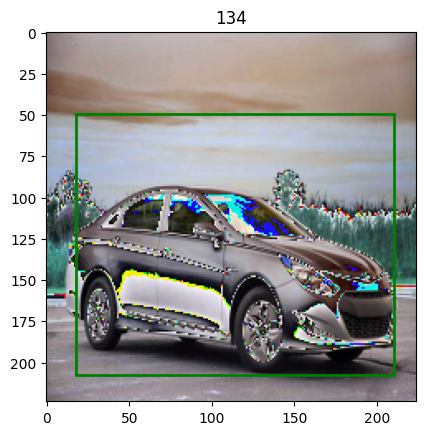

In [46]:
fig, ax = plt.subplots(1)
ax.imshow(PIL_image)
rect = patches.Rectangle((a0,b0), width, height, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.title(train_class[25])
plt.show()

In [47]:
# Generate one hot encoding for train classes
train_classDummy = pd.get_dummies(train_class)
train_classDummy.head()

1    2    3    4    5    6    7    8    9    10   ...  187  188  189  190  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    1    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   191  192  193  194  195  196  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 196 columns]

In [48]:
# Generate one hot encoding for test classes
test_classDummy = pd.get_dummies(test_class)
test_classDummy.head()

1    2    3    4    5    6    7    8    9    10   ...  187  188  189  190  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    1    0    0    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   191  192  193  194  195  196  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 196 columns]

In [49]:
# Training the classification model for 10 epochs with batch size of 32
classification_history = classificationModel.fit(x=train_images, y=train_classDummy, batch_size=32, epochs=10, validation_data=(test_images,test_classDummy))

Epoch 1/10
255/255 [==============================] - 26s 54ms/step - loss: 4.2758 - accuracy: 0.1089 - val_loss: 3.4853 - val_accuracy: 0.1903
Epoch 2/10
255/255 [==============================] - 7s 29ms/step - loss: 1.7032 - accuracy: 0.5662 - val_loss: 3.1698 - val_accuracy: 0.2583
Epoch 3/10
255/255 [==============================] - 8s 29ms/step - loss: 0.4308 - accuracy: 0.9015 - val_loss: 2.9942 - val_accuracy: 0.3099
Epoch 4/10
255/255 [==============================] - 8s 30ms/step - loss: 0.1522 - accuracy: 0.9677 - val_loss: 3.0059 - val_accuracy: 0.3343
Epoch 5/10
255/255 [==============================] - 7s 29ms/step - loss: 0.1028 - accuracy: 0.9784 - val_loss: 3.1900 - val_accuracy: 0.3150
Epoch 6/10
255/255 [==============================] - 8s 30ms/step - loss: 0.0771 - accuracy: 0.9854 - val_loss: 3.2102 - val_accuracy: 0.3283
Epoch 7/10
255/255 [==============================] - 8s 30ms/step - loss: 0.0905 - accuracy: 0.9805 - val_loss: 3.8857 - val_accuracy: 0.268

Note: Due to the Google colab RAM memory issue, We have run the model separately and also limited the epoches to 10

In [50]:
classification_history

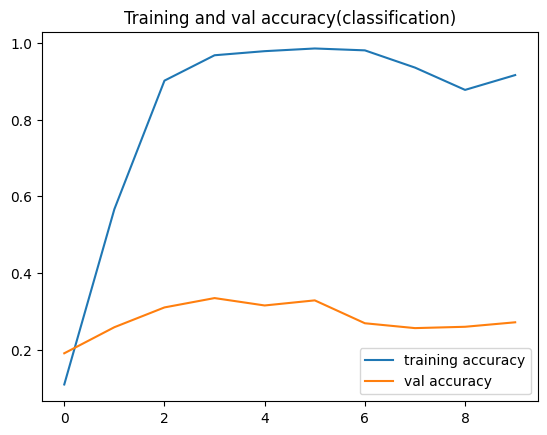

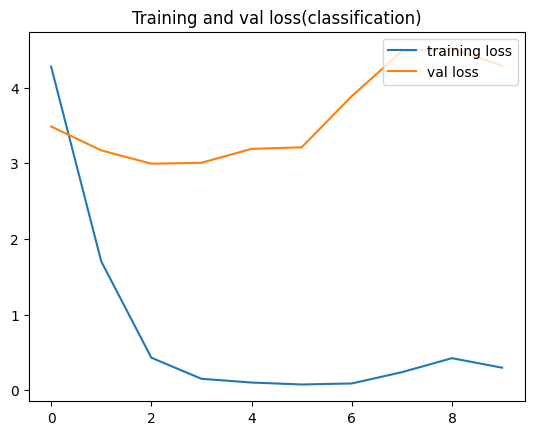

In [51]:
# Training and validation accuracy for classification
accuracy = classification_history.history['accuracy']
val_accuracy = classification_history.history['val_accuracy']
loss = classification_history.history['loss']
val_loss = classification_history.history['val_loss']

# Get the accuracy value of each epochs
epochs = range(len(accuracy))

# plotting score
plt.plot(epochs, accuracy, label = 'training accuracy' )
plt.plot(epochs, val_accuracy, label = 'val accuracy' )
plt.title('Training and val accuracy(classification)')
plt.legend(loc = 'lower right')
plt.figure()

# plotting loss
plt.plot(epochs, loss, label = 'training loss' )
plt.plot(epochs, val_loss, label = 'val loss' )
plt.legend(loc = 'upper right')
plt.title('Training and val loss(classification)')
plt.show()

In [52]:
# fitting the model
boundingbox_history = boundingboxModel.fit(x=train_images, y=train_boundingbox, batch_size=32, epochs=10, validation_data=(test_images,test_boundingbox))

Epoch 1/10


UnboundLocalError: ignored

In [ ]:
# Training and validation accuracy for boundingbox
IoU_score = boundingbox_history.history['IoU']
val_IoU_score = boundingbox_history.history['val_IoU']
loss = boundingbox_history.history['loss']
val_loss = boundingbox_history.history['val_loss']

# Get the accuracy value of each epochs
epochs = range(len(IoU_score))

# plotting score
plt.plot(epochs, IoU_score, label = 'training: IoU score' )
plt.plot(epochs, val_IoU_score, label = 'validation: IoU score' )
plt.title('Training and val accuracy(bounding box)')
plt.legend(loc = 'lower right')
plt.figure()

# plotting loss
plt.plot(epochs, loss, label = 'training loss' )
plt.plot(epochs, val_loss, label = 'val loss' )
plt.legend(loc = 'upper right')
plt.title('Training and val loss(bounding box)')
plt.show()

#### Insights

<li> Training accuracy is much more than testing/validation accuracy which indicates the overfit of the model
<li> From graphs we can see, training accuracy is almost 100% but the validation accuracy is below 50%
<li> Due to the resizeing image, the accuracy value might have reduced
<li> Hypertuning has to be done for improving the performance of the model


# **Milestone 2:**

# **Fine tuning the model**

Finetunning with changing hyperparameter - number of epochs can be adjusted during the training process, allowing for fine-tuning of the model. This can help to improve the performance of the model.

In [53]:
# Fine tunning the model by increasing EPOCH size
classification_history1 = classificationModel.fit(x=train_images, y=train_classDummy, batch_size=32, epochs=20, validation_data=(test_images,test_classDummy))

Epoch 1/20
255/255 [==============================] - 13s 50ms/step - loss: 0.1730 - accuracy: 0.9479 - val_loss: 4.3030 - val_accuracy: 0.2935
Epoch 2/20
255/255 [==============================] - 8s 30ms/step - loss: 0.1239 - accuracy: 0.9619 - val_loss: 4.2986 - val_accuracy: 0.3029
Epoch 3/20
255/255 [==============================] - 8s 30ms/step - loss: 0.1221 - accuracy: 0.9655 - val_loss: 4.5016 - val_accuracy: 0.2900
Epoch 4/20
255/255 [==============================] - 8s 29ms/step - loss: 0.1309 - accuracy: 0.9613 - val_loss: 4.6060 - val_accuracy: 0.2909
Epoch 5/20
255/255 [==============================] - 7s 29ms/step - loss: 0.0988 - accuracy: 0.9708 - val_loss: 4.7271 - val_accuracy: 0.2944
Epoch 6/20
255/255 [==============================] - 8s 29ms/step - loss: 0.1033 - accuracy: 0.9684 - val_loss: 4.7700 - val_accuracy: 0.2957
Epoch 7/20
255/255 [==============================] - 8s 30ms/step - loss: 0.1434 - accuracy: 0.9602 - val_loss: 5.2671 - val_accuracy: 0.283

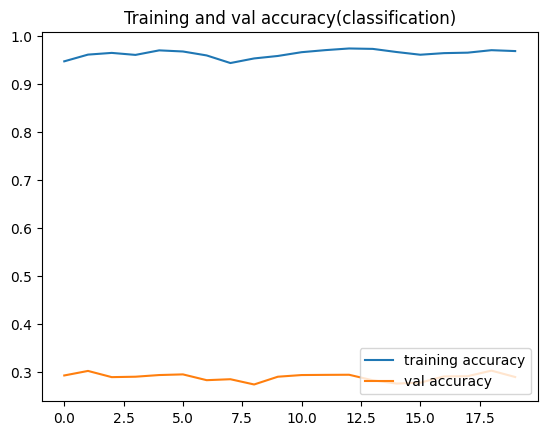

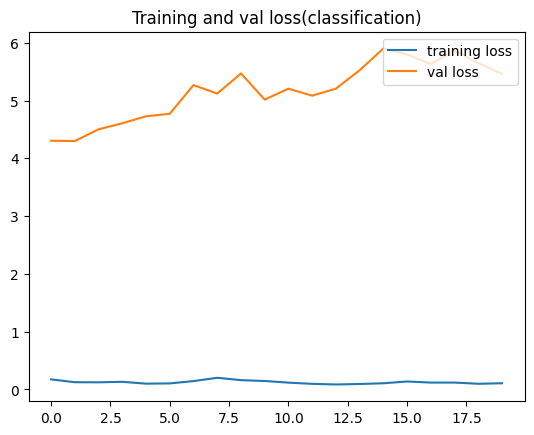

In [54]:
# Training and validation accuracy for classification after finetuning the model
accuracy = classification_history1.history['accuracy']
val_accuracy = classification_history1.history['val_accuracy']
loss = classification_history1.history['loss']
val_loss = classification_history1.history['val_loss']

# Get the accuracy value of each epochs
epochs = range(len(accuracy))

# plotting score
plt.plot(epochs, accuracy, label = 'training accuracy' )
plt.plot(epochs, val_accuracy, label = 'val accuracy' )
plt.title('Training and val accuracy(classification)')
plt.legend(loc = 'lower right')
plt.figure()

# plotting loss
plt.plot(epochs, loss, label = 'training loss' )
plt.plot(epochs, val_loss, label = 'val loss' )
plt.legend(loc = 'upper right')
plt.title('Training and val loss(classification)')
plt.show()

## **RCNN model**

RCNN (Region-based Convolutional Neural Network) is a family of object detection models that use a combination of convolutional neural networks (CNNs) and region proposal methods to locate and classify objects within images.

### **The RCNN model follow the idea of these steps:**

1. Searching regions for objects

2. Cropping image for actual object and neglegting other areas. Proposedregions are cropped out of the image and resized

3. Use that image to CNN model

In [55]:
# Installing necessary library

!pip uninstall --yes opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.8.0.76
Uninstalling opencv-contrib-python-4.8.0.76:
  Successfully uninstalled opencv-contrib-python-4.8.0.76
  Using cached opencv_contrib_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.8 MB)


In [56]:
# Importing libraries

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Iou function to evaluate the performance of object detection models by comparing predicted bounding boxes to ground truth bounding boxes.

In [57]:
# Defining Iou and selective search segmentation


cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()   # create Selective Search Segmentation Object using default parameters
def Iou(box1, box2):

# Calculating the (x, y)-coordinates of the intersection rectangle

    assert box1['x1'] < box1['x2'] # Ground truth bounding box
    assert box1['y1'] < box1['y2']

    assert box2['x1'] < box2['x2'] # Predicted bounding box
    assert box2['y1'] < box2['y2'];

    x_left = max(box1['x1'], box2['x1'])
    y_top = max(box1['y1'], box2['y1'])
    x_right = min(box1['x2'], box2['x2'])
    y_bottom = min(box1['y2'], box2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)             # calculating the area of intersection rectangle
    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])       # calculating area of Ground truth box
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])       # calculating area of Predicted box
    score = intersection_area / float(box1_area + box2_area - intersection_area)    # Intersection area
    assert score >= 0.0
    assert score <= 1.0
    return score          # return the intersection over union value

### **Preraing Train data**

Shape of image: (224, 224, 3)
Total Number of Region Proposals: 521


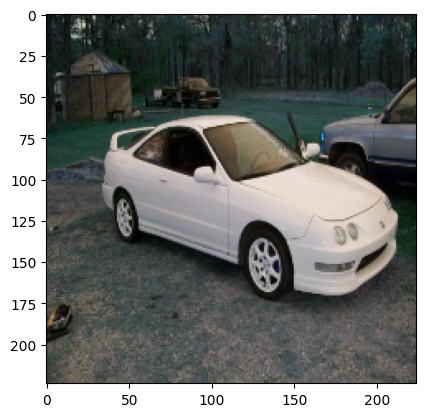

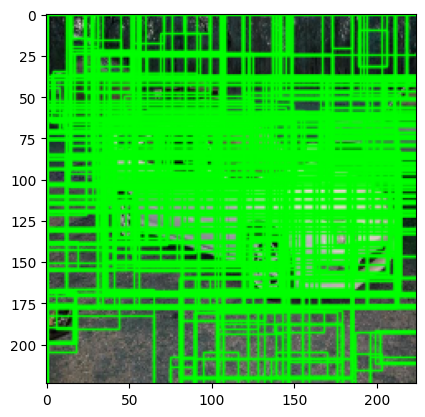

In [58]:
# Performing selective search regions in one train sample
# Using OpenCV's Selective Search algorithm to generate region proposals and visualize them on an input image

image1 = cv2.imread('/content/drive/My Drive/Capstone_project/Car Images/Train Images/Acura Integra Type R 2001/00198.jpg')  # Reading image from folder on which we want to perform selective search algorithm
image1=cv2.resize(image1,(224,224))   # resize image
plt.figure()
plt.imshow(image1)  # to show image
ss.setBaseImage(image1)   # set input image on which we want to run segmentation
ss.switchToSelectiveSearchFast() # Selective Search
rects = ss.process()  # performing selective search segmentation on sample image

print('Shape of image:',image1.shape)
print('Total Number of Region Proposals: {}'.format(len(rects)))

# Drawing rectangle boxes for proposed regions

for name in rects:
  x, y, w, h = name
  image1_final=cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(image1_final);

In [59]:
# turning trainAnnotate into standard format with image and coordinates only

trainAnnotate1 = trainAnnotate.drop(['class', 'car_image_path','class_name'], axis=1)

In [60]:
# Viewing updated dataframe
trainAnnotate1.head()

image_file   a0   b0    a1    b1
0  00001.jpg   39  116   569   375
1  00002.jpg   36  116   868   587
2  00003.jpg   85  109   601   381
3  00004.jpg  621  393  1484  1096
4  00005.jpg   14   36   133    99

In [61]:
# Selective serach algorithm for all images on train data to find possible regions
# cropping images having object
# IOU score threshold = 0.5
# If the IoU score is greater than 0.5, crop the image using the coordinates of the proposal, resize it to (224, 224), and append it to the train_image_list with a label of 1


train_image_list=[]
m=0
n=0
p=0

for a in trainAnnotate1.values:
  image_file,a0,b0,a1,b1=a
  box1={
            'x1':int(a0),
            'y1':int(b0),
            'x2':int(a1),
            'y2':int(b1)
            }
  try:
    img=cv2.imread('/content/drive/My Drive/Capstone_project/Car Images/Train Images/Acura Integra Type R 2001/'+image_file)  # Reading images from main folder
    ss.setBaseImage(img)   # set input image on which we want to run segmentation
    ss.switchToSelectiveSearchFast() # Fast Selective Search
    rects = ss.process() # performing selective search segmentation on sample image

   # Drawing rectangle boxes for proposed regions

    for i in rects:
      x, y, w, h = i
      box2={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[box2['y1']:box2['y2'],box2['x1']:box2['x2']] # Cropping imgage
      img1_shape=cv2.resize(img1,(224,224))
      if m<n:
            if 0.5<Iou(box1,box2):
              train_image_list.append([img1_shape,1])
              m+=1
      else:
        if 0.5<Iou(box1,box2):
          train_image_list.append([img1_shape,1])
          m+=1
        else:
          train_image_list.append([img1_shape,0])
          n+=1
  #If there is any exception (e.g., invalid bounding box coordinates), catch print the exception.
  except Exception as e:
    print(e)
  p+=1
  print(image_file,p,len(rects))

Streaming output truncated to the last 5000 lines.
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06471.jpg 6471 4442
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06472.jpg 6472 4442
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06473.jpg 6473 4442
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06474.jpg 6474 4442
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06475.jpg 6475 4442
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06476.jpg 6476 4442
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:

In [62]:
# samples (regions) in training data, indicates that this much samples using for training our model
#  Images selected having IOU score threshold > 0.5 for training our model
len(train_image_list)

3983

In [63]:
# extracting the features (cropped and resized images) and their corresponding labels and storing them in train_data and train_data_label, respectively
# Data labeling with object found or not
# 0 =  not found
# 1 =  Object found


train_data=[]
train_data_label=[]
for features,label in train_image_list:
  train_data.append(features)
  train_data_label.append(label)


In [64]:
# Verifying length of data and data labeling

print('Length of data',len(train_data))
print('Length of data label',len(train_data_label))


Length of data 3983
Length of data label 3983


Class of Image: 0
Shape of Image: (224, 224, 3)


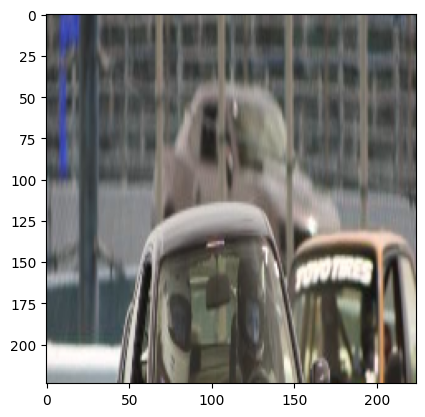

In [65]:
# Randomly selecting an image from your training data, printing its class label and shape, and then displaying the image using Matplotlib

k=random.randint(1,3979)
print('Class of Image:',train_data_label[k])
print('Shape of Image:',train_data[k].shape)
plt.imshow(train_data[k]);

In [66]:
# converting data into array input format. Suitable for model building

train_data=np.asarray(train_data)
train_data_label=np.asarray(train_data_label)

In [67]:
# Defining x_train and y_traing data
# This train data will be used in model building
x_train = train_data
y_train = train_data_label

## **Preraing Test data**

Shape of image: (224, 224, 3)
Total Number of Region Proposals: 634


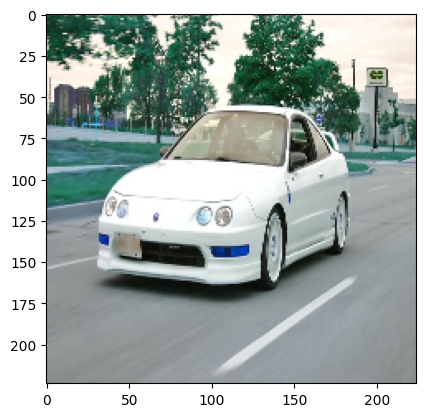

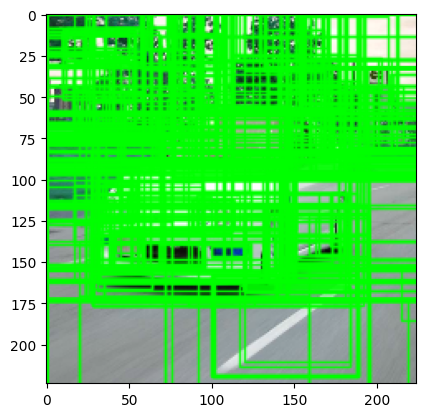

In [68]:
# Performing selective search regions in one test sample to check
# Using OpenCV's Selective Search algorithm to generate region proposals and visualize them on an input image

image1 = cv2.imread('/content/drive/My Drive/Capstone_project/Car Images/Test Images/Acura Integra Type R 2001/00128.jpg')
image1=cv2.resize(image1,(224,224)) # resize image
plt.figure()
plt.imshow(image1)   # to show image
ss.setBaseImage(image1) # set input image on which we want to run segmentation
ss.switchToSelectiveSearchFast() # Selective Search
rects = ss.process()  # performing selective search segmentation on sample image


print('Shape of image:',image1.shape)
print('Total Number of Region Proposals: {}'.format(len(rects)))

# Drawing rectangle boxes for proposed regions
for rect in rects:
  x, y, w, h = rect
  image1_final=cv2.rectangle(image1, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(image1_final);


In [69]:
testAnnotate.head()
trainAnnotate1= testAnnotate

In [70]:
trainAnnotate1.head()

image_file   a0   b0   a1   b1  class  \
0  00001.jpg   30   52  246  147    181   
1  00002.jpg  100   19  576  203    103   
2  00003.jpg   51  105  968  659    145   
3  00004.jpg   67   84  581  407    187   
4  00005.jpg  140  151  593  339    185   

                                      car_image_path  \
0  /content/drive/My Drive/Capstone_project//Car ...   
1  /content/drive/My Drive/Capstone_project//Car ...   
2  /content/drive/My Drive/Capstone_project//Car ...   
3  /content/drive/My Drive/Capstone_project//Car ...   
4  /content/drive/My Drive/Capstone_project//Car ...   

                            class_name  
0              Suzuki Aerio Sedan 2007  
1  Ferrari 458 Italia Convertible 2012  
2                Jeep Patriot SUV 2012  
3              Toyota Camry Sedan 2012  
4             Tesla Model S Sedan 2012

In [71]:
# turning testAnnotate into standard format with image and coordinates only
testAnnotate1 = testAnnotate.drop(['class', 'car_image_path','class_name'], axis=1)
testAnnotate1.head()

image_file   a0   b0   a1   b1
0  00001.jpg   30   52  246  147
1  00002.jpg  100   19  576  203
2  00003.jpg   51  105  968  659
3  00004.jpg   67   84  581  407
4  00005.jpg  140  151  593  339

In [72]:
# Selective serach algorithm for all images on test data to find possible regions
# cropping images having object
# IOU threshold = 0.5
# If the IoU score is greater than 0.5, crop the image using the coordinates of the proposal, resize it to (224, 224), and append it to the test_image_list with a label of 1

image_test_list=[]
m=0
n=0
p=0
for a in testAnnotate1.values:
  image_file,a0,b0,a1,b1=a
  box1={
            'x1':int(a0),
            'y1':int(b0),
            'x2':int(a1),
            'y2':int(b1)
            }
  try:
    img=cv2.imread('/content/drive/My Drive/Capstone_project/Car Images/Test Images/Acura Integra Type R 2001/'+image_file)
    ss.setBaseImage(img)  # set input image on which we want to run segmentation
    ss.switchToSelectiveSearchFast() # Set fast selective search
    rects = ss.process()  # performing selective search segmentation on sample image

   # Drawing rectangle boxes for proposed regions

    for i in rects:
      x, y, w, h = i
      box2={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[box2['y1']:box2['y2'],box2['x1']:box2['x2']] # Cropping imgage
      img1_shape=cv2.resize(img1,(224,224))
      if m<n:
            if 0.5<Iou(box1,box2):
              image_test_list.append([img1_shape,1])
              m+=1
      else:
        if 0.5<Iou(box1,box2):
          image_test_list.append([img1_shape,1])
          m+=1
        else:
          image_test_list.append([img1_shape,0])
          n+=1
  #If there is any exception (e.g., invalid bounding box coordinates), catch print the exception.
  except Exception as e:
    print(e)
  p+=1
  print(image_file,p,len(rects))

Streaming output truncated to the last 5000 lines.
06370.jpg 6370 3942
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06371.jpg 6371 3942
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06372.jpg 6372 3942
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06373.jpg 6373 3942
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06374.jpg 6374 3942
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06375.jpg 6375 3942
OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

06376.jpg 6376 3942
OpenCV(4.8.0) /io/opencv/modules/im

In [73]:
# samples (regions) in training data, indicates that this much samples using for test data

len(image_test_list)  # Checking number of images selected

4025

In [74]:
# extracting the features (cropped and resized images) and their corresponding labels and storing them in test_data and test_data_label, respectively
# Data labeling with object found or not
# 0 =  not found
# 1 =  Object found

test_data=[]
test_data_label=[]
for features,label in image_test_list:
  test_data.append(features)
  test_data_label.append(label)


In [75]:
# Verifying length of data and data labeling

print('Length of test_data = ',len(test_data))
print('Length of test_data label = ',len(test_data_label))

Length of test_data =  4025
Length of test_data label =  4025


Class of Image: 1
Shape of image: (224, 224, 3)


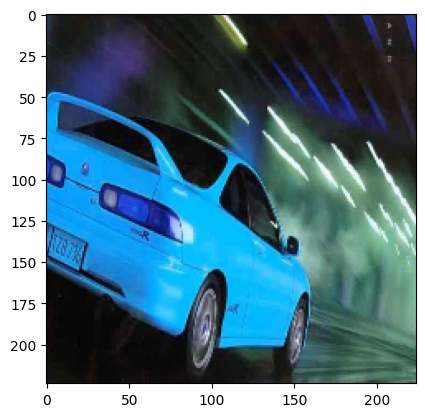

In [76]:
# # Randomly selecting an image from your training data, printing its class label and shape, and then displaying the image using Matplotlib

k=random.randint(1,4029)
print('Class of Image:',test_data_label[k])
print('Shape of image:',test_data[k].shape)
plt.imshow(test_data[k]);

In [77]:
# converting data into array input format. Suitable for model building

test_data=np.asarray(test_data)
test_data_label=np.asarray(test_data_label)

In [78]:
# Defining x_train and y_traing data
# This train data will be used in model building

x_test = test_data
y_test = test_data_label

## **Building Model**

In [79]:
# Printing shape of train and test data to check data

print('x_train shape:',x_train.shape)
print('x_test shape:',x_test.shape)
print('y_train shape:',y_train.shape)
print('y_test shape:',y_test.shape)

x_train shape: (3983, 224, 224, 3)
x_test shape: (4025, 224, 224, 3)
y_train shape: (3983,)
y_test shape: (4025,)


In [80]:
# loading pre-trained VGG Model for object detection using keras
# freeze its weights, and print a summary of the model architecture
# using this pre-trained VGG16 model as a feature extractor
# VGG16 model are listed along with their trainable status, which is set to False. This means that the weights of these layers are frozen, and they won't be updated during training

VGG_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')
VGG_model.trainable=False
VGG_model.summary()  # printing VGG model summary

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [81]:
# Building model

model=tf.keras.Sequential()
model.add(VGG_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

Model architecture can be summarized as follows:

1. VGG16 (pre-trained feature extractor)

2. Global Average Pooling 2D

3. Dropout

4. Dense layer with sigmoid activation (for binary classification)

In [82]:
model.summary()  # printing model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [83]:
# prints information about each layer, including its index, name, and whether it's trainable or not

for i,layer in enumerate(VGG_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_3 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [84]:
# compiling model
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [85]:
# Training model using the model.fit()
# set the number of training epochs to 30. An epoch represents one pass through the entire training dataset during training
epoch=30
history=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_test,y_test))

Epoch 1/30
125/125 [==============================] - 9s 56ms/step - loss: 1.9551 - accuracy: 0.7123 - val_loss: 0.5478 - val_accuracy: 0.8912
Epoch 2/30
125/125 [==============================] - 5s 40ms/step - loss: 0.8686 - accuracy: 0.8461 - val_loss: 0.4665 - val_accuracy: 0.9120
Epoch 3/30
125/125 [==============================] - 5s 39ms/step - loss: 0.6327 - accuracy: 0.8843 - val_loss: 0.4143 - val_accuracy: 0.9125
Epoch 4/30
125/125 [==============================] - 5s 39ms/step - loss: 0.4760 - accuracy: 0.8915 - val_loss: 0.3057 - val_accuracy: 0.9250
Epoch 5/30
125/125 [==============================] - 5s 40ms/step - loss: 0.3440 - accuracy: 0.9086 - val_loss: 0.2953 - val_accuracy: 0.9277
Epoch 6/30
125/125 [==============================] - 5s 40ms/step - loss: 0.3082 - accuracy: 0.9151 - val_loss: 0.2641 - val_accuracy: 0.9292
Epoch 7/30
125/125 [==============================] - 5s 40ms/step - loss: 0.3152 - accuracy: 0.9159 - val_loss: 0.2359 - val_accuracy: 0.9257

# Accuracy is around 93%

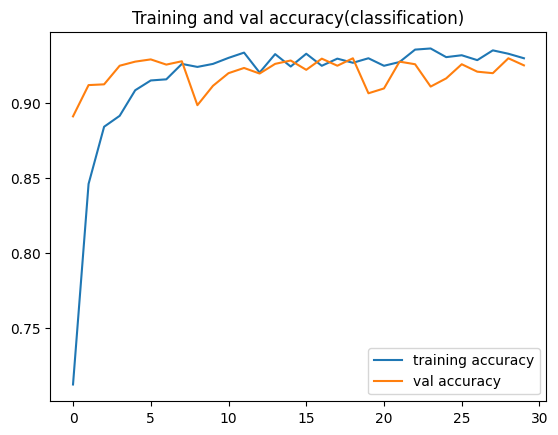

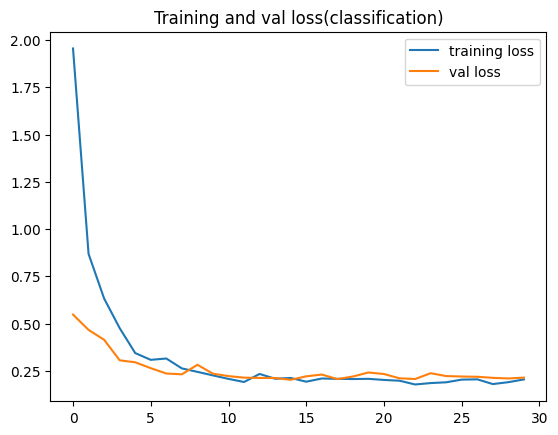

In [86]:
# Plotting accuracy and validation loss curve
#Training and validation accuracy for classification

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the accuracy value of each epochs
epochs = range(len(accuracy))

# plotting score
plt.plot(epochs, accuracy, label = 'training accuracy' )
plt.plot(epochs, val_accuracy, label = 'val accuracy' )
plt.title('Training and val accuracy(classification)')
plt.legend(loc = 'lower right')
plt.figure()

# plotting loss
plt.plot(epochs, loss, label = 'training loss' )
plt.plot(epochs, val_loss, label = 'val loss' )
plt.legend(loc = 'upper right')
plt.title('Training and val loss(classification)')
plt.show()

## Prediction on test data to verify the accuracy

In [87]:
# imorting necessary libraries

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [88]:
# Load the test image
photo_path = '/content/drive/My Drive/Capstone_project/Car Images/Test Images/Acura Integra Type R 2001/00128.jpg'
Test_image = cv2.imread(photo_path)

# Initialize Selective Search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(Test_image)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()

# Initialize an empty list to store predictions
prediction_list = []

# Process region proposals
for x, y, w, h in rects1:
    # Create a bounding box dictionary
    box = {
        'x1': x,
        'y1': y,
        'x2': x + w,
        'y2': y + h
    }

    try:
        # Check if the bounding box coordinates are valid
        assert box['x1'] < box['x2']
        assert box['y1'] < box['y2']

        # Crop and resize the region
        img_data = Test_image[box['y1']:box['y2'], box['x1']:box['x2']]
        img_data = cv2.resize(img_data, (224, 224))

        # Make predictions on the cropped and resized image using the trained model
        pred = model.predict(img_data.reshape(1, 224, 224, 3))

        if pred[0] > 0.5:
            # If the prediction score is greater than 0.5, append the bounding box and prediction score
            prediction_list.append([box, pred[0]])

    except Exception as e:
        # If there is any exception (e.g., invalid bounding box coordinates), catch and print the exception
        print(e)

1/1 [==============================] - 0s 21ms/step


Printing sample image to see
----------------------------------------------------------------------
Prediction accuracy on sample image: 99.96%


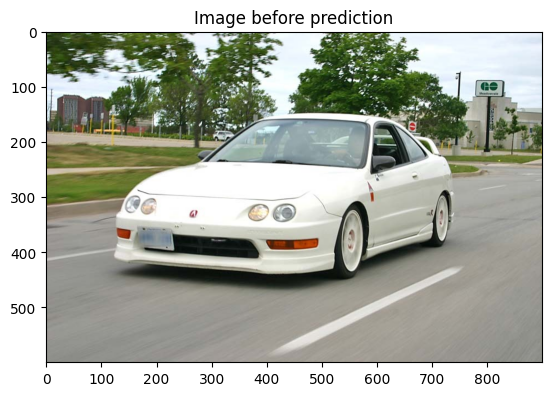

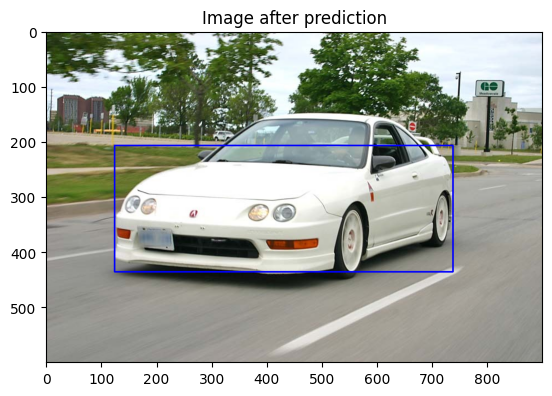

In [89]:
# Finding accuracy of model using argmax function
# Checking with a sample image

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the test image
Test_image = cv2.imread(photo_path)

# Find the index of the bounding box with the highest prediction score
max_score_index = np.argmax(np.array(prediction_list)[:, 1])

# Extract the coordinates of the bounding box
max_score_box = prediction_list[max_score_index][0]

# Define the top-left and bottom-right points of the bounding box
pt1 = (max_score_box['x1'], max_score_box['y1'])
pt2 = (max_score_box['x2'], max_score_box['y2'])

# Create a new Matplotlib figure for visualization
plt.figure()

# Print a message
print('Printing sample image to see')
print('----------------------------------------------------------------------')

# Display the original test image
plt.title(f'Image before prediction')
plt.imshow(cv2.cvtColor(Test_image, cv2.COLOR_BGR2RGB))

# Draw the bounding box on the test image (in blue)
cv2.rectangle(Test_image, pt1, pt2, (255, 0, 0), 2)

# Create another Matplotlib figure for visualization
plt.figure()

# Display the test image after drawing the bounding box
plt.title(f'Image after prediction')
plt.imshow(cv2.cvtColor(Test_image, cv2.COLOR_BGR2RGB))

# Calculate and print the prediction accuracy based on the highest prediction score
accuracy = prediction_list[np.argmax(np.array(prediction_list)[:, 1])][1][0] * 100
print(f'Prediction accuracy on sample: {accuracy:.2f}%')

## **Pickel the Model**

In [90]:
# importing library

import pickle

In [111]:
# Saving model into model.pkl pickled file

with open('/content/drive/My Drive/Capstone_project/RCNN_model.pkl', "wb") as file: # file is a variable for storing the newly created file, it can be anything.
    pickle.dump(model, file) # Dump function is used to write the object into the created file in byte format.

In [115]:
# Opening saved model
with open('/content/drive/My Drive/Capstone_project/RCNN_model.pkl', "rb") as file:
    loaded_model = pickle.load(file)


In [120]:
# Loading saved pickled model

loaded_model = pickle.load(open('model.pkl', 'rb'))
predictions = loaded_model.predict(x_test)
print(predictions)

126/126 [==============================] - 2s 17ms/step
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.000

In [117]:
import cv2
from sklearn.metrics import accuracy_score
# Load the image
image = cv2.imread('/content/drive/My Drive/Capstone_project/Car Images/Test Images/Acura Integra Type R 2001/00128.jpg')

In [119]:

# Use the loaded model to make predictions on the test data
y_pred = loaded_model.predict(x_test)


126/126 [==============================] - 2s 17ms/step


In [131]:
import os
import cv2

def load_test_data(test_data_dir):
    test_images = []
    ground_truth_labels = []

    # List all files in the test data directory
    for filename in os.listdir(test_data_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # Assuming images are in JPEG or PNG format
            image_path = os.path.join(test_data_dir, filename)

            # Load the image using OpenCV
            image = cv2.imread(image_path)

            if image is not None:
                # Extract the ground truth label from the filename
                # Example filename format: "image1_class1.jpg"
                parts = filename.split('_')
                if len(parts) >= 2:
                    label = int(parts[1])  # Assuming the label is in the filename
                    test_images.append(image)
                    ground_truth_labels.append(label)

    return test_images, ground_truth_labels

# Example usage:

test_images, ground_truth_labels = load_test_data(test_data_dir)

In [134]:
import cv2
import numpy as np

def preprocess_images(images, target_size=(224, 224)):
    preprocessed_images = []

    for image in images:
        # Resize the image to the target size
        resized_image = cv2.resize(image, target_size)

        # Normalize pixel values to the range [0, 1]
        normalized_image = resized_image.astype(np.float32) / 255.0

        # Add any other necessary preprocessing steps here
        # For example, you can subtract the mean pixel value

        preprocessed_images.append(normalized_image)

    return np.array(preprocessed_images)

# Example usage:
# Assuming you have loaded test_images using the load_test_data function
preprocessed_images = preprocess_images(test_images)

In [139]:
test_data_dir = '/content/drive/My Drive/Capstone_project/Car Images/Test Images/Acura Integra Type R 2001/'